In [0]:
!pip install tensorflow==1.15
!pip install "tensorflow_hub>=0.6.0"
!pip3 install tensorflow_text==1.15

import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
from sklearn import preprocessing
import keras
import numpy as np
from nltk.tokenize import word_tokenize
import nltk
import tarfile
nltk.download('punkt')
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
from sklearn import preprocessing
import keras
import numpy as np
!pip install bert-tensorflow
from keras.layers import Input, Lambda, Dense
from keras.models import Model
import keras.backend as K
!pip install keras_metrics
import keras_metrics
!pip install transformers
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization
from tensorflow import keras
import os
import re

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## **loading data and preprocess**

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&state=NRsXXsYY9f8LDLg92MVWhWJa2LNl8e&code_challenge=QehlETekuoWz4-gCT23fWMdvXsVR9v0pBxPsbUrVMPU&prompt=consent&code_challenge_method=S256&access_type=offline

Enter verification code: ··········


In [0]:
link = 'https://drive.google.com/open?id=1d2o9uC_UsEx0wOLy4YuwyucM3Yc-vze7'
fluff, id = link.split('=')
print (id)
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('spam.csv')  
df = pd.read_csv('spam.csv', encoding='latin-1')
df['v1'] = df.v1.map({'ham': 0, 'spam': 1})
msk = np.random.rand(len(df)) < 0.8
df_train = df[msk]
df_test = df[~msk]
train_sentences = df_train.v2.values
train_labels = df_train.v1.values
test_sentences = df_test.v2.values
test_labels = df_test.v1.values

train_sentences = [word_tokenize(s) for s in train_sentences]
nltk.download('stopwords')
pre_sen = []
for tokens in train_sentences:
  tokens = [w.lower() for w in tokens]
  import string
  table = str.maketrans('', '', string.punctuation)
  stripped = [w.translate(table) for w in tokens]
  # remove remaining tokens that are not alphabetic
  words = [word for word in stripped if word.isalpha()]
  # filter out stop words
  from nltk.corpus import stopwords
  stop_words = set(stopwords.words('english'))
  words = [w for w in words if not w in stop_words]
  pre_sen.append(words)
train_sentences = pre_sen

t_sen = []
from nltk.tokenize.treebank import TreebankWordDetokenizer
for s in train_sentences:
  if(len(s)<128):
    t_sen.append(TreebankWordDetokenizer().detokenize(s))
  else:
    t_sen.append(TreebankWordDetokenizer().detokenize(s[0:127]))
train_sentences = t_sen

test_sentences = [word_tokenize(s) for s in test_sentences]
pre_sen = []
for tokens in test_sentences:
  tokens = [w.lower() for w in tokens]
  import string
  table = str.maketrans('', '', string.punctuation)
  stripped = [w.translate(table) for w in tokens]
  # remove remaining tokens that are not alphabetic
  words = [word for word in stripped if word.isalpha()]
  # filter out stop words
  from nltk.corpus import stopwords
  stop_words = set(stopwords.words('english'))
  words = [w for w in words if not w in stop_words]
  pre_sen.append(words)
test_sentences = pre_sen
t_sen = []
for s in test_sentences:
  if(len(s)<128):
    t_sen.append(TreebankWordDetokenizer().detokenize(s))
  else:
    t_sen.append(TreebankWordDetokenizer().detokenize(s[0:127]))
test_sentences = t_sen

In [0]:
# !pip install transformers
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-cased', do_lower_case=True)
train_input_ids = []
train_input_masks = []
train_segment_ids = []
for sent in train_sentences:
      encoded_dict = tokenizer.encode_plus(sent,add_special_tokens = True,max_length = 128,pad_to_max_length = True,return_attention_mask = True)
      train_input_ids.append(encoded_dict['input_ids'])
      train_input_masks.append(encoded_dict['attention_mask'])
      train_segment_ids.append(encoded_dict['token_type_ids'])

In [0]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-cased', do_lower_case=True)
test_input_ids = []
test_input_masks = []
test_segment_ids = []
for sent in test_sentences:
      encoded_dict = tokenizer.encode_plus(sent,add_special_tokens = True,max_length = 128,pad_to_max_length = True,return_attention_mask = True)
      test_input_ids.append(encoded_dict['input_ids'])
      test_input_masks.append(encoded_dict['attention_mask'])
      test_segment_ids.append(encoded_dict['token_type_ids'])

## **building model**

In [0]:
class BertLayer(tf.keras.layers.Layer):
    def __init__(self, n_fine_tune_layers=10, **kwargs):
        self.n_fine_tune_layers = n_fine_tune_layers
        self.trainable = True
        self.output_size = 768
        super(BertLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.bert = hub.Module(
            'https://tfhub.dev/google/bert_cased_L-12_H-768_A-12/1',
            trainable=self.trainable,
            name="{}_module".format(self.name)
        )
        trainable_vars = self.bert.variables
        
        # Remove unused layers
        trainable_vars = [var for var in trainable_vars if not "/cls/" in var.name]
        
        # Select how many layers to fine tune
        trainable_vars = trainable_vars[-self.n_fine_tune_layers :]
        
        # Add to trainable weights
        for var in trainable_vars:
            self._trainable_weights.append(var)
        
        # Add non-trainable weights
        for var in self.bert.variables:
            if var not in self._trainable_weights:
                self._non_trainable_weights.append(var)
        
        super(BertLayer, self).build(input_shape)

    def call(self, inputs):
        inputs = [K.cast(x, dtype="int32") for x in inputs]
        input_ids, input_mask, segment_ids = inputs
        bert_inputs = dict(input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids)
        result = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)["pooled_output"]
        return result

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_size)

In [0]:
def build_model(): 
    in_id = tf.keras.layers.Input(shape=(128,), name="input_ids")
    in_mask = tf.keras.layers.Input(shape=(128,), name="input_masks")
    in_segment = tf.keras.layers.Input(shape=(128,), name="segment_ids")
    bert_inputs = [in_id, in_mask, in_segment]
    
    bert_output = BertLayer(n_fine_tune_layers=5)(bert_inputs)
    dense = tf.keras.layers.Dense(768, activation='relu')(bert_output)
    pred = tf.keras.layers.Dense(1, activation='sigmoid')(dense)
    
    model = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)
    ada = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(loss='binary_crossentropy', optimizer=ada, metrics=['accuracy'])
    model.summary()
    
    return model

def initialize_vars(sess):
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    K.set_session(sess)

## **10 epochs**

In [0]:
model = build_model()
sess = tf.Session()
# Instantiate variables
initialize_vars(sess)
history = model.fit(
    [train_input_ids, train_input_masks, train_segment_ids], 
    train_labels,
    validation_data=([test_input_ids, test_input_masks, test_segment_ids], test_labels),
    epochs=10,
    batch_size=200
)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
bert_layer_2 (BertLayer)        (None, 768)          108931396   input_ids[0][0]                  
                                                                 input_masks[0][0]          

In [0]:
model.save_weights('./bert-model_spam1.h5')

In [0]:
predict = model.predict([test_input_ids, test_input_masks, test_segment_ids])

In [0]:
pred = []
for t in predict:
  if(t<0.5):
    pred.append(0)
  else :
    pred.append(1)

yr = test_labels

AUC :  0.9425278515687401
accuracy :  0.9791304347826087
precision :  0.9685534591194969
recall :  0.8901734104046243
F1 :  0.927710843373494


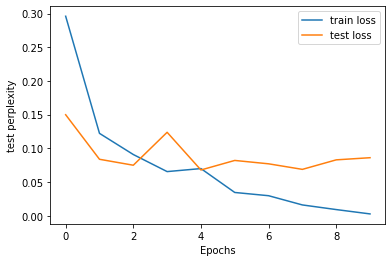

In [0]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(yr, pred, pos_label=1)
print("AUC : ",metrics.auc(fpr, tpr))

from sklearn.metrics import accuracy_score
print("accuracy : ",accuracy_score(yr,pred))

from sklearn.metrics import precision_score
print("precision : ",precision_score(yr, pred))

from sklearn.metrics import recall_score
print("recall : " ,recall_score(yr, pred) )

from sklearn.metrics import f1_score
print("F1 : ", f1_score(yr, pred))

import matplotlib.pyplot as plt
import numpy as np
import math
hist2=history.history
loss=hist2['loss']
val_loss=hist2['val_loss']
plt.xlabel('Epochs')
plt.ylabel('train loss')
plt.plot(loss)

plt.xlabel('Epochs')
plt.ylabel('test perplexity')
plt.plot(val_loss)
plt.legend(['train loss','test loss'])

## **20 epochs**

In [0]:
model2 = build_model()
sess = tf.Session()
# Instantiate variables
initialize_vars(sess)

history2 = model2.fit(
    [train_input_ids, train_input_masks, train_segment_ids], 
    train_labels,
    validation_data=([test_input_ids, test_input_masks, test_segment_ids], test_labels),
    epochs=20,
    batch_size=200
)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
bert_layer_3 (BertLayer)        (None, 768)          108931396   input_ids[0][0]                  
                                                                 input_masks[0][0]          

In [0]:
model2.save_weights('./bert-model_spam2.h5')
# model2.load_weights('./bert-model_spam2.h5')

In [0]:
predict2 = model2.predict([test_input_ids, test_input_masks, test_segment_ids])

In [0]:
pred = []
for t in predict2:
  if(t<0.5):
    pred.append(0)
  else :
    pred.append(1)

In [0]:
yr = test_labels

AUC :  0.9454180249791445
accuracy :  0.98
precision :  0.96875
recall :  0.8959537572254336
F1 :  0.9309309309309309


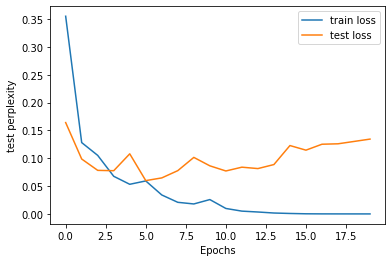

In [0]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(yr, pred, pos_label=1)
print("AUC : ",metrics.auc(fpr, tpr))

from sklearn.metrics import accuracy_score
print("accuracy : ",accuracy_score(yr,pred))

from sklearn.metrics import precision_score
print("precision : ",precision_score(yr, pred))

from sklearn.metrics import recall_score
print("recall : " ,recall_score(yr, pred) )

from sklearn.metrics import f1_score
print("F1 : ", f1_score(yr, pred))

import matplotlib.pyplot as plt
import numpy as np
import math
hist2=history2.history
loss=hist2['loss']
val_loss=hist2['val_loss']
plt.xlabel('Epochs')
plt.ylabel('train loss')
plt.plot(loss)

plt.xlabel('Epochs')
plt.ylabel('test perplexity')
plt.plot(val_loss)
plt.legend(['train loss','test loss'])

## **50 epochs**

In [0]:
import tensorflow as tf
tf.test.gpu_device_name()
# gpu_options = tf.GPUOptions(allow_growth=True)
# session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

'/device:GPU:0'

In [0]:
model50 = build_model()
sess = tf.Session()
# Instantiate variables
initialize_vars(sess)

history50 = model50.fit(
    [train_input_ids, train_input_masks, train_segment_ids], 
    train_labels,
    validation_data=([test_input_ids, test_input_masks, test_segment_ids], test_labels),
    epochs=50,
    batch_size=20
)

INFO:absl:Using /tmp/tfhub_modules to cache modules.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
bert_layer (BertLayer)          (None, 768)          108931396   input_ids[0][0]                  
                                                                 input_masks[0][0]            

In [0]:
predict50 = model50.predict([test_input_ids, test_input_masks, test_segment_ids])

In [0]:
pred = []
for t in predict50:
  if(t<0.5):
    pred.append(0)
  else :
    pred.append(1)
yr = test_labels

AUC :  0.9525258799171842
accuracy :  0.9811827956989247
precision :  0.9448275862068966
recall :  0.9133333333333333
F1 :  0.9288135593220338


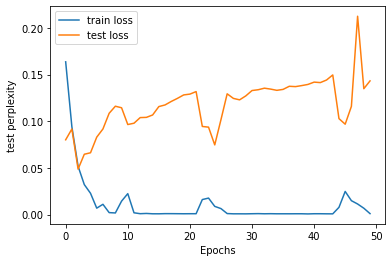

In [0]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(yr, pred, pos_label=1)
print("AUC : ",metrics.auc(fpr, tpr))

from sklearn.metrics import accuracy_score
print("accuracy : ",accuracy_score(yr,pred))

from sklearn.metrics import precision_score
print("precision : ",precision_score(yr, pred))

from sklearn.metrics import recall_score
print("recall : " ,recall_score(yr, pred) )

from sklearn.metrics import f1_score
print("F1 : ", f1_score(yr, pred))

import matplotlib.pyplot as plt
import numpy as np
import math
hist2=history50.history
loss=hist2['loss']
val_loss=hist2['val_loss']
plt.xlabel('Epochs')
plt.ylabel('train loss')
plt.plot(loss)

plt.xlabel('Epochs')
plt.ylabel('test perplexity')
plt.plot(val_loss)
plt.legend(['train loss','test loss'])

## **without preprocessing**

In [0]:
model_pre = build_model()
sess = tf.Session()
# Instantiate variables
initialize_vars(sess)
history_pre = model_pre.fit(
    [train_input_ids, train_input_masks, train_segment_ids], 
    train_labels,
    validation_data=([test_input_ids, test_input_masks, test_segment_ids], test_labels),
    epochs=10,
    batch_size=200
)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
bert_layer_10 (BertLayer)       (None, 768)          108931396   input_ids[0][0]                  
                                                                 input_masks[0][0]         

In [0]:
predict_pre = model_pre.predict([test_input_ids, test_input_masks, test_segment_ids])

In [0]:
pred = []
for t in predict_pre:
  if(t<0.5):
    pred.append(0)
  else :
    pred.append(1)
yr = test_labels

AUC :  0.9659511077611532
accuracy :  0.9879931389365352
precision :  0.9813664596273292
recall :  0.9349112426035503
F1 :  0.9575757575757575


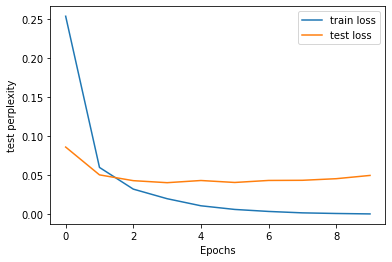

In [0]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(yr, pred, pos_label=1)
print("AUC : ",metrics.auc(fpr, tpr))

from sklearn.metrics import accuracy_score
print("accuracy : ",accuracy_score(yr,pred))

from sklearn.metrics import precision_score
print("precision : ",precision_score(yr, pred))

from sklearn.metrics import recall_score
print("recall : " ,recall_score(yr, pred) )

from sklearn.metrics import f1_score
print("F1 : ", f1_score(yr, pred))

import matplotlib.pyplot as plt
import numpy as np
import math
hist2=history_pre.history
loss=hist2['loss']
val_loss=hist2['val_loss']
plt.xlabel('Epochs')
plt.ylabel('train loss')
plt.plot(loss)

plt.xlabel('Epochs')
plt.ylabel('test perplexity')
plt.plot(val_loss)
plt.legend(['train loss','test loss'])

## **بخش امتیازی**

In [0]:
def build_model2(): 
    in_id = tf.keras.layers.Input(shape=(128,), name="input_ids")
    in_mask = tf.keras.layers.Input(shape=(128,), name="input_masks")
    in_segment = tf.keras.layers.Input(shape=(128,), name="segment_ids")
    bert_inputs = [in_id, in_mask, in_segment]
    
    bert_output = BertLayer(n_fine_tune_layers=5)(bert_inputs)
    dense = tf.keras.layers.Dense(256, activation='relu')(bert_output)
    dense2 = tf.keras.layers.Dense(768, activation='relu')(dense)
    pred = tf.keras.layers.Dense(1, activation='sigmoid')(dense2)
    
    model = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)
    ada = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(loss='binary_crossentropy', optimizer=ada, metrics=['accuracy'])
    model.summary()
    
    return model

In [0]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
model3 = build_model()
sess = tf.Session()
# Instantiate variables
initialize_vars(sess)
history3 = model3.fit([train_input_ids, train_input_masks, train_segment_ids], 
    train_labels,
    validation_data=([test_input_ids, test_input_masks, test_segment_ids], test_labels),
    epochs=10,
    batch_size=20)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
bert_layer_11 (BertLayer)       (None, 768)          108931396   input_ids[0][0]                  
                                                                 input_masks[0][0]         

In [0]:
predict3 = model3.predict([test_input_ids, test_input_masks, test_segment_ids])

In [0]:
pred = []
for t in predict3:
  if(t<0.5):
    pred.append(0)
  else :
    pred.append(1)
yr = test_labels

AUC :  0.9758298564332049
accuracy :  0.9922813036020584
precision :  0.9938271604938271
recall :  0.9526627218934911
F1 :  0.972809667673716


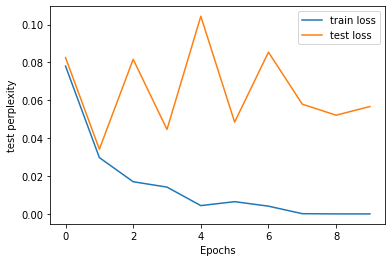

In [0]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(yr, pred, pos_label=1)
print("AUC : ",metrics.auc(fpr, tpr))

from sklearn.metrics import accuracy_score
print("accuracy : ",accuracy_score(yr,pred))

from sklearn.metrics import precision_score
print("precision : ",precision_score(yr, pred))

from sklearn.metrics import recall_score
print("recall : " ,recall_score(yr, pred) )

from sklearn.metrics import f1_score
print("F1 : ", f1_score(yr, pred))

import matplotlib.pyplot as plt
import numpy as np
import math
hist2=history3.history
loss=hist2['loss']
val_loss=hist2['val_loss']
plt.xlabel('Epochs')
plt.ylabel('train loss')
plt.plot(loss)

plt.xlabel('Epochs')
plt.ylabel('test perplexity')
plt.plot(val_loss)
plt.legend(['train loss','test loss'])

In [0]:
def build_model4(): 
    in_id = tf.keras.layers.Input(shape=(128,), name="input_ids")
    in_mask = tf.keras.layers.Input(shape=(128,), name="input_masks")
    in_segment = tf.keras.layers.Input(shape=(128,), name="segment_ids")
    bert_inputs = [in_id, in_mask, in_segment]
    
    bert_output = BertLayer(n_fine_tune_layers=5)(bert_inputs)
    dense = tf.keras.layers.Dense(16, activation='relu')(bert_output)
    dense2 = tf.keras.layers.Dense(32, activation='relu')(dense)
    dense3 = tf.keras.layers.Dense(64, activation='relu')(dense2)
    dense4 = tf.keras.layers.Dense(128, activation='relu')(dense3)
    dense5 = tf.keras.layers.Dense(256, activation='relu')(dense4)
    pred = tf.keras.layers.Dense(1, activation='sigmoid')(dense5)
    
    model = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)
    ada = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(loss='binary_crossentropy', optimizer=ada, metrics=['accuracy'])
    model.summary()
    
    return model

In [0]:
model5 = build_model4()
sess = tf.Session()
# Instantiate variables
initialize_vars(sess)
history5 = model5.fit([train_input_ids, train_input_masks, train_segment_ids], 
    train_labels,
    validation_data=([test_input_ids, test_input_masks, test_segment_ids], test_labels),
    epochs=10,
    batch_size=5)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
bert_layer_18 (BertLayer)       (None, 768)          108931396   input_ids[0][0]                  
                                                                 input_masks[0][0]         

FailedPreconditionError: ignored

In [0]:
predict3 = model3.predict([test_input_ids, test_input_masks, test_segment_ids])